# Описание задачи

Описание

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

Цель: предсказать вероятность покупки в течение 90 дней

Задачи

● Изучить данные

● Разработать полезные признаки

● Создать модель для классификации пользователей

● Улучшить модель и максимизировать метрику roc_auc

● Выполнить тестирование

Данные

apparel-purchases

история покупок

● client_id идентификатор пользователя

● quantity количество товаров в заказе

● price цена товара

● category_ids вложенные категории, к которым отнсится товар

● date дата покупки

● message_id идентификатор сообщения из рассылки

apparel-messages

история рекламных рассылок

● bulk_campaign_id идентификатор рекламной кампании

● client_id идентификатор пользователя

● message_id идентификатор сообщений

● event тип действия

● channel канал рассылки

● date дата рассылки

● created_at точное время создания сообщения

apparel-target_binary

совершит ли клиент покупку в течение следующих 90 дней

● client_id идентификатор пользователя

● target целевой признак

Результат

Репозиторий на гитхабе:

● тетрадь jupyter notebook с описанием, подготовкой признаков, обучением модели и тестированием

● описание проекта и инструкция по использованию в файле README.md

● список зависимостей в файле requirements.txt

Стэк

● python

● pandas

● sklearn

# Предобработка данных

In [20]:
# Загрузим необходимые библиотеки
!pip install catboost lightgbm tuna
!pip install optuna
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve
from imblearn.over_sampling import SMOTE



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Загрузим данные
messages = pd.read_csv('apparel-messages.csv')
purchases = pd.read_csv('apparel-purchases.csv')
target_binary = pd.read_csv('apparel-target_binary.csv')

In [3]:
# Посмотрим на данные
display(messages.head())
display(purchases.head())
display(target_binary.head())

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [4]:
# Проверим типы данных
messages.info()
purchases.info()
target_binary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB
<class 'pandas.core.frame.DataFrame'>
Ra

In [5]:
# В датафрейме messages меняем тип данных в столбце date на date, в столбце created_at на datetime
messages["date"] = pd.to_datetime(messages["date"]).dt.date  # Преобразуем в тип date
messages["created_at"] = pd.to_datetime(messages["created_at"])  # Преобразуем в тип datetime

# В датафрейме purchases меняем тип данных в столбце date на date, в столбце created_at на datetime
purchases["date"] = pd.to_datetime(purchases["date"]).dt.date  # Преобразуем в тип date

In [6]:
# Проверяем наличие пропусков
missing_messages = messages.isna().sum()
missing_purchases = purchases.isna().sum()
missing_target_binary = target_binary.isna().sum()

# Выводим результат
print("Пропуски в messages:")
print(missing_messages)

print("\nПропуски в purchases:")
print(missing_purchases)

print("\nПропуски в target_binary:")
print(missing_target_binary)

Пропуски в messages:
bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

Пропуски в purchases:
client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

Пропуски в target_binary:
client_id    0
target       0
dtype: int64


In [7]:
# Проверяем наличие дубликатов
duplicates_messages = messages.duplicated().sum()
duplicates_purchases = purchases.duplicated().sum()
duplicates_target_binary = target_binary.duplicated().sum()

# Выводим результат
print("Дубликаты в messages:", duplicates_messages)
print("Дубликаты в purchases:", duplicates_purchases)
print("Дубликаты в target_binary:", duplicates_target_binary)

Дубликаты в messages: 48610
Дубликаты в purchases: 73020
Дубликаты в target_binary: 0


Дубликаты в purchases оставляем, т.к. это могут быть повторяющиеся покупки в один день одним клиентом.

In [8]:
# Удалим дубликаты в messages
messages = messages.drop_duplicates()
duplicates_messages = messages.duplicated().sum()
print("Дубликаты в messages:", duplicates_messages)

Дубликаты в messages: 0


Для того, чтобы обработать столбец category_ids, найдем максимально глубокую категорию, удовлетрворяющую следующему условию: категория перед ней уникальна для нее. Это позволит сделать больше категорий и придать им нормальный вид.

In [9]:
# Извлекаем первую, вторую, третью и четвёртую категории
purchases['first_category'] = purchases['category_ids'].apply(lambda x: x[0])
purchases['second_category'] = purchases['category_ids'].apply(lambda x: x[1])
purchases['third_category'] = purchases['category_ids'].apply(lambda x: x[2] if len(x) > 2 else None)
purchases['fourth_category'] = purchases['category_ids'].apply(lambda x: x[3] if len(x) > 3 else None)

# Проверяем уникальность первой категории относительно второй
first_vs_second = purchases.groupby('second_category')['first_category'].nunique()

# Проверяем уникальность второй категории относительно третьей
second_vs_third = purchases.groupby('third_category')['second_category'].nunique()

# Проверяем уникальность третьей категории относительно четвёртой
third_vs_fourth = purchases.groupby('fourth_category')['third_category'].nunique()

# Вывод результата
print("Количество уникальных первых категорий для каждой второй категории:")
print(first_vs_second)

print("\nКоличество уникальных вторых категорий для каждой третьей категории:")
print(second_vs_third)

print("\nКоличество уникальных третьих категорий для каждой четвёртой категории:")
print(third_vs_fourth)

# Анализ нарушений
print("\nАнализ нарушений уникальности:")

if not first_vs_second[first_vs_second > 1].empty:
    print("\nВторая категория с более чем одной уникальной первой категорией:")
    print(first_vs_second[first_vs_second > 1])
else:
    print("\nВсе первые категории уникальны относительно своих вторых категорий.")

if not second_vs_third[second_vs_third > 1].empty:
    print("\nТретья категория с более чем одной уникальной второй категорией:")
    print(second_vs_third[second_vs_third > 1])
else:
    print("\nВсе вторые категории уникальны относительно своих третьих категорий.")

if not third_vs_fourth[third_vs_fourth > 1].empty:
    print("\nЧетвёртая категория с более чем одной уникальной третьей категорией:")
    print(third_vs_fourth[third_vs_fourth > 1])
else:
    print("\nВсе третьи категории уникальны относительно своих четвёртых категорий.")

Количество уникальных первых категорий для каждой второй категории:
second_category
'    1
N    1
]    1
Name: first_category, dtype: int64

Количество уникальных вторых категорий для каждой третьей категории:
third_category
1    1
2    1
3    1
4    1
5    1
6    1
o    1
Name: second_category, dtype: int64

Количество уникальных третьих категорий для каждой четвёртой категории:
fourth_category
'    5
0    1
5    1
9    1
n    1
Name: third_category, dtype: int64

Анализ нарушений уникальности:

Все первые категории уникальны относительно своих вторых категорий.

Все вторые категории уникальны относительно своих третьих категорий.

Четвёртая категория с более чем одной уникальной третьей категорией:
fourth_category
'    5
Name: third_category, dtype: int64


В результате проверки на уникальность, мы выяснили, что можем оставить только третью категорию товарной группы, чтобы повысить точность данных.

In [10]:
# Преобразуем строковые списки в реальные списки
purchases['category_ids'] = purchases['category_ids'].apply(eval)

# Извлекаем третью категорию в столбец final_category
purchases['final_category'] = purchases['category_ids'].apply(lambda x: int(x[2]) if len(x) > 2 else None)

# Удаляем лишние столбцы
purchases = purchases.drop(columns=['category_ids', 'first_category', 'second_category', 'third_category', 'fourth_category'])

# Вывод результата
print(purchases)

                  client_id  quantity   price        date  \
0       1515915625468169594         1  1999.0  2022-05-16   
1       1515915625468169594         1  2499.0  2022-05-16   
2       1515915625471138230         1  6499.0  2022-05-16   
3       1515915625471138230         1  4999.0  2022-05-16   
4       1515915625471138230         1  4999.0  2022-05-16   
...                     ...       ...     ...         ...   
202203  1515915626010261344         1  1499.0  2024-02-16   
202204  1515915626010439406         1    99.0  2024-02-16   
202205  1515915626010439406         1    99.0  2024-02-16   
202206  1515915626010443527         1  1999.0  2024-02-16   
202207  1515915626010443624         1   999.0  2024-02-16   

                                     message_id  final_category  
0        1515915625468169594-4301-627b661e9736d            57.0  
1        1515915625468169594-4301-627b661e9736d            57.0  
2        1515915625471138230-4437-6282242f27843            57.0  
3  

Далее оставим в датасетах только те строки, в которых client_id содержится в датасете с таргетом.

In [11]:
# Список датафреймов для обработки
dataframes = {'messages': messages, 'purchases': purchases}

# Функция для фильтрации и подсчёта удалённых строк
def filter_dataframes_by_target(dataframes, target_binary):
    results = {}
    for name, df in dataframes.items():
        # Изначальное количество строк
        initial_rows = len(df)

        # Фильтруем строки, оставляя только те, где client_id содержится в target_binary
        filtered_df = df[df['client_id'].isin(target_binary['client_id'])]

        # Количество удалённых строк
        removed_rows = initial_rows - len(filtered_df)

        # Сохраняем результат
        results[name] = {
            'filtered_df': filtered_df,
            'removed_rows': removed_rows
        }

        # Перезаписываем оригинальный датафрейм
        dataframes[name] = filtered_df

        # Вывод информации
        print(f"\n{name}:")
        print(f"Изначальное количество строк: {initial_rows}")
        print(f"Количество удалённых строк: {removed_rows}")
        print(f"Оставшееся количество строк: {len(filtered_df)}")

    return results

# Применяем фильтрацию
filtered_results = filter_dataframes_by_target(dataframes, target_binary)

# Датафреймы после фильтрации
messages = dataframes['messages']
purchases = dataframes['purchases']

# Вывод обновлённых датафреймов
print("\nОбновлённый messages:")
display(messages)

print("\nОбновлённый purchases:")
display(purchases)


messages:
Изначальное количество строк: 12691188
Количество удалённых строк: 1777991
Оставшееся количество строк: 10913197

purchases:
Изначальное количество строк: 202208
Количество удалённых строк: 0
Оставшееся количество строк: 202208

Обновлённый messages:


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
...,...,...,...,...,...,...,...
12739793,14657,1515915625477497874,1515915625477497874-14657-65cdd371cc86c,open,email,2024-02-15,2024-02-15 23:51:40
12739794,14657,1515915625765994334,1515915625765994334-14657-65cdd36018eac,open,email,2024-02-15,2024-02-15 23:52:20
12739795,14641,1515915625545014677,1515915625545014677-14641-65cb2434b25a1,open,email,2024-02-15,2024-02-15 23:52:40
12739796,14624,1515915625477497874,1515915625477497874-14624-65c5e22fb401e,open,email,2024-02-15,2024-02-15 23:58:40



Обновлённый purchases:


,client_id,quantity,price,date,message_id,final_category
0,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,57.0
1,1515915625468169594,1,2499.0,2022-05-16,1515915625468169594-4301-627b661e9736d,57.0
2,1515915625471138230,1,6499.0,2022-05-16,1515915625471138230-4437-6282242f27843,57.0
3,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,244.0
4,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,49.0
...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,2024-02-16,1515915626010261344-14648-65cdb6d56c4c8,212.0
202204,1515915626010439406,1,99.0,2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,233.0
202205,1515915626010439406,1,99.0,2024-02-16,1515915625776605028-14662-65cf3abfe4f0d,233.0
202206,1515915626010443527,1,1999.0,2024-02-16,1515915625766077627-14668-65cf5246bd490,274.0


# Создание новых признаков и объединение датасетов

Для группировки датасета purchases по клиенту, добавим следующие признаки:

Описание всех новых столбцов:

total_quantity:

Описание: Общее количество единиц товаров, купленных клиентом.
Метод расчёта: Суммирование значений столбца quantity для всех записей клиента.
Интерпретация: Показывает, сколько товаров в общей сложности приобрёл клиент.

total_spent:

Описание: Общая сумма денег, потраченных клиентом.
Метод расчёта: Сумма произведений quantity * price для всех записей клиента.
Интерпретация: Указывает, сколько денег клиент потратил за весь анализируемый период.

median_price:

Описание: Медианная цена товаров, купленных клиентом.
Метод расчёта: Медианное значение столбца price для всех записей клиента.
Интерпретация: Отражает типичный ценовой уровень, на котором совершает покупки клиент, исключая влияние экстремально высоких или низких цен.

unique_categories:

Описание: Количество уникальных категорий товаров, в которых клиент делал покупки.
Метод расчёта: Объединение множеств category_ids для всех записей клиента и подсчёт уникальных элементов.
Интерпретация: Показывает разнообразие покупок клиента по категориям товаров.

purchase_count:

Описание: Общее количество покупок клиента.
Метод расчёта: Количество строк (записей) для клиента в исходном датафрейме.
Интерпретация: Указывает, сколько транзакций клиент совершил за весь анализируемый период.

activity_period:

Описание: Период активности клиента.
Метод расчёта: Разница между последней и первой датой покупки (last_purchase_date - first_purchase_date).
Интерпретация: Отражает, насколько долго клиент оставался активным в течение анализируемого периода.

last_purchase_distance:

Описание: Время, прошедшее с момента последней покупки клиента.
Метод расчёта: Разница между (максимальная дата в датасете + 1 день) и датой последней покупки (last_purchase_date).
Интерпретация: Чем больше значение, тем дольше клиент не совершал покупок. Полезно для анализа "спящих" клиентов.

unique_message_ids:

Описание: Количество уникальных идентификаторов сообщений, полученных клиентом.
Метод расчёта: Подсчёт уникальных значений столбца message_id для клиента.
Интерпретация: Отражает, сколько разных маркетинговых сообщений клиент получил.

most_common_category:

Описание: Наиболее часто встречающаяся категория в покупках клиента.
Метод расчёта: Модальное значение среди всех категорий клиента (самое частое значение).
Интерпретация: Показывает категорию товаров, которая наиболее интересна клиенту.

In [12]:
# Вычисляем максимальную дату в датасете
max_date = purchases['date'].max()

# Группировка данных по client_id
purchases_grouped = purchases.groupby('client_id').agg(
    total_quantity=('quantity', 'sum'),  # Сумма всех quantity
    total_spent=('price', lambda x: (purchases.loc[x.index, 'quantity'] * x).sum()),  # Общая сумма (quantity * price)
    median_price=('price', 'median'),  # Медианная цена
    purchase_count=('quantity', 'count'),  # Количество строк (покупок)
    first_purchase_date=('date', 'min'),  # Дата первой покупки
    last_purchase_date=('date', 'max'),  # Дата последней покупки
    unique_categories=('final_category', 'nunique'),  # Количество уникальных категорий
    unique_message_ids=('message_id', 'nunique')  # Количество уникальных message_id
)

# Добавляем новые признаки
purchases_grouped['activity_period'] = purchases_grouped['last_purchase_date'] - purchases_grouped['first_purchase_date']
purchases_grouped['last_purchase_distance'] = (max_date + pd.Timedelta(days=1)) - purchases_grouped['last_purchase_date']

# Удаляем временные столбцы (опционально)
purchases_grouped = purchases_grouped.drop(columns=['first_purchase_date', 'last_purchase_date'])

# Вывод результата
display(purchases_grouped)

,total_quantity,total_spent,median_price,purchase_count,unique_categories,unique_message_ids,activity_period,last_purchase_distance
client_id,,,,,,,,
1515915625468060902,7,6993.0,999.0,7,5,1,0:00:00,"631 days, 0:00:00"
1515915625468061003,7,16235.0,2100.0,7,1,1,0:00:00,"409 days, 0:00:00"
1515915625468061099,1,299.0,299.0,1,1,1,0:00:00,"641 days, 0:00:00"
1515915625468061100,2,2098.0,1049.0,2,1,1,0:00:00,"7 days, 0:00:00"
1515915625468061170,19,33601.0,2195.0,19,3,3,"83 days, 0:00:00","245 days, 0:00:00"
...,...,...,...,...,...,...,...,...
1515915626010261344,6,8994.0,1499.0,6,1,1,0:00:00,"1 day, 0:00:00"
1515915626010266132,2,1818.0,909.0,2,1,1,0:00:00,"3 days, 0:00:00"
1515915626010439406,2,198.0,99.0,2,1,1,0:00:00,"1 day, 0:00:00"


Для группировки датасета messages по клиенту, добавим следующие признаки:

Описание всех новых столбцов:

message_count:

Описание: Общее количество сообщений, отправленных клиенту.
Метод расчёта: Подсчёт всех строк в датафрейме messages, относящихся к клиенту.
Интерпретация: Показывает, насколько активно клиент получал рассылки.

unique_event_types:

Описание: Количество уникальных типов событий, связанных с сообщениями клиента.
Метод расчёта: Подсчёт уникальных значений в столбце event (например, open, click, purchase) для клиента.
Интерпретация: Показывает, как разнообразно клиент взаимодействовал с сообщениями (например, открывал, кликал, совершал покупки).

unique_bulk_campaigns:

Описание: Количество уникальных кампаний, в которых участвовал клиент.
Метод расчёта: Подсчёт уникальных значений в столбце bulk_campaign_id для клиента.
Интерпретация: Указывает, насколько разнообразными были маркетинговые активности, направленные на клиента.

unique_channels:

Описание: Количество уникальных каналов рассылки, через которые взаимодействовал клиент.
Метод расчёта: Подсчёт уникальных значений в столбце channel (например, email, sms) для клиента.
Интерпретация: Показывает, сколько различных способов взаимодействия использовалось для клиента.

message_activity_period:

Описание: Период активности клиента в рассылках.
Метод расчёта: Разница между датой последнего (last_message_date) и первого (first_message_date) сообщения.
Интерпретация: Отражает временной интервал, в течение которого клиент получал сообщения.

last_message_distance:

Описание: Время, прошедшее с момента последнего сообщения до (максимальная дата в датасете + 1 день).
Метод расчёта: (максимальная дата + 1 день) - last_message_date.
Интерпретация: Указывает, как давно клиент в последний раз получал сообщение. Полезно для анализа "спящих" клиентов, которым давно не отправляли рассылки

In [13]:
# Находим максимальную дату в датасете
max_date = messages['date'].max()

# Группируем данные по client_id
messages_grouped = messages.groupby('client_id').agg(
    message_count=('message_id', 'count'),  # Общее количество сообщений
    unique_event_types=('event', 'nunique'),  # Количество уникальных типов событий
    unique_bulk_campaigns=('bulk_campaign_id', 'nunique'),  # Количество уникальных кампаний
    unique_channels=('channel', 'nunique'),  # Количество уникальных каналов
    first_message_date=('date', 'min'),  # Дата первого сообщения
    last_message_date=('date', 'max'),  # Дата последнего сообщения
)

# Добавляем вычисляемые метрики
messages_grouped['message_activity_period'] = (
    messages_grouped['last_message_date'] - messages_grouped['first_message_date']
)  # Период активности клиента в рассылках

messages_grouped['last_message_distance'] = (
    (max_date + pd.Timedelta(days=1)) - messages_grouped['last_message_date']
)  # Дальность последнего сообщения

# Удаляем временные столбцы (опционально)
messages_grouped = messages_grouped.drop(columns=['first_message_date', 'last_message_date'])

# Вывод результата
display(messages_grouped)

,message_count,unique_event_types,unique_bulk_campaigns,unique_channels,message_activity_period,last_message_distance
client_id,,,,,,
1515915625468060902,177,5,127,1,"610 days, 0:00:00","28 days, 0:00:00"
1515915625468061003,165,4,154,1,"634 days, 0:00:00","3 days, 0:00:00"
1515915625468061099,276,4,215,2,"635 days, 0:00:00","3 days, 0:00:00"
1515915625468061100,428,6,265,1,"637 days, 0:00:00","1 day, 0:00:00"
1515915625468061170,293,4,240,2,"631 days, 0:00:00","1 day, 0:00:00"
...,...,...,...,...,...,...
1515915626010079153,3,3,1,1,"1 day, 0:00:00","3 days, 0:00:00"
1515915626010152263,5,3,1,1,0:00:00,"2 days, 0:00:00"
1515915626010183608,4,2,2,1,0:00:00,"1 day, 0:00:00"


Объединим датасеты в один по client_id. Заполним загрушками пропуски.

In [14]:
# Преобразуем строки в timedelta
purchases_grouped['activity_period'] = pd.to_timedelta(purchases_grouped['activity_period'])
purchases_grouped['last_purchase_distance'] = pd.to_timedelta(purchases_grouped['last_purchase_distance'])
messages_grouped['message_activity_period'] = pd.to_timedelta(messages_grouped['message_activity_period'])
messages_grouped['last_message_distance'] = pd.to_timedelta(messages_grouped['last_message_distance'])

# Шаг 1: Объединение purchases_grouped и messages_grouped
merged_df = purchases_grouped.merge(
    messages_grouped,
    on='client_id',
    how='left'
)

# Шаг 2: Объединение с target_binary
merged_df = merged_df.merge(
    target_binary,
    on='client_id',
    how='left'
)

# Шаг 3: Заполнение заглушками
default_values = {
    'total_quantity': 0,               # Заглушка для количества товаров
    'total_spent': 0.0,                # Заглушка для общей суммы
    'median_price': 0.0,               # Заглушка для медианной цены
    'purchase_count': 0,               # Заглушка для количества покупок
    'unique_categories': 0,            # Заглушка для уникальных категорий
    'unique_message_ids': 0,           # Заглушка для уникальных сообщений
    'activity_period': pd.Timedelta(days=0),  # Заглушка для активности покупок
    'last_purchase_distance': pd.Timedelta(days=0),  # Заглушка для времени с последней покупки
    'message_count': 0,                # Заглушка для количества сообщений
    'unique_event_types': 0,           # Заглушка для уникальных событий
    'unique_bulk_campaigns': 0,        # Заглушка для уникальных кампаний
    'unique_channels': 0,              # Заглушка для уникальных каналов
    'message_activity_period': pd.Timedelta(days=0),  # Заглушка для активности сообщений
    'last_message_distance': pd.Timedelta(days=0)     # Заглушка для времени с последнего сообщения
}

merged_df = merged_df.fillna(default_values)

# Вывод результата
display(merged_df)

,client_id,total_quantity,total_spent,median_price,purchase_count,unique_categories,unique_message_ids,activity_period,last_purchase_distance,message_count,unique_event_types,unique_bulk_campaigns,unique_channels,message_activity_period,last_message_distance,target
0,1515915625468060902,7,6993.0,999.0,7,5,1,0 days,631 days,177.0,5.0,127.0,1.0,610 days,28 days,0
1,1515915625468061003,7,16235.0,2100.0,7,1,1,0 days,409 days,165.0,4.0,154.0,1.0,634 days,3 days,1
2,1515915625468061099,1,299.0,299.0,1,1,1,0 days,641 days,276.0,4.0,215.0,2.0,635 days,3 days,0
3,1515915625468061100,2,2098.0,1049.0,2,1,1,0 days,7 days,428.0,6.0,265.0,1.0,637 days,1 days,0
4,1515915625468061170,19,33601.0,2195.0,19,3,3,83 days,245 days,293.0,4.0,240.0,2.0,631 days,1 days,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,6,8994.0,1499.0,6,1,1,0 days,1 days,3.0,3.0,1.0,1.0,0 days,1 days,0
49845,1515915626010266132,2,1818.0,909.0,2,1,1,0 days,3 days,0.0,0.0,0.0,0.0,0 days,0 days,0
49846,1515915626010439406,2,198.0,99.0,2,1,1,0 days,1 days,0.0,0.0,0.0,0.0,0 days,0 days,0
49847,1515915626010443527,1,1999.0,1999.0,1,1,1,0 days,1 days,0.0,0.0,0.0,0.0,0 days,0 days,0


In [15]:
# Проверим на наличие дубликатов
merged_df.duplicated().sum()

0

# Обучение моделей и предсказания

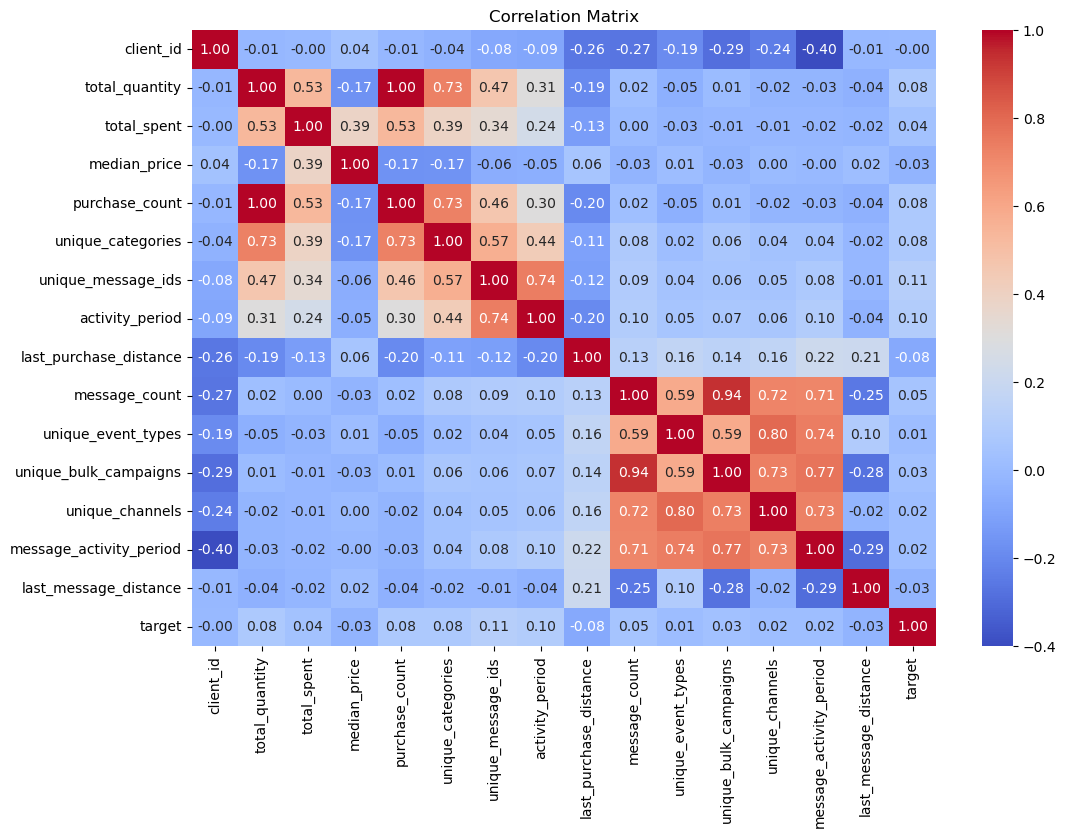

client_id удалён из данных.
target удалён из признаков.
Удалённые признаки из-за высокой корреляции:
         feature_removed highly_correlated_with  correlation
0         purchase_count         total_quantity     0.996603
1  unique_bulk_campaigns          message_count     0.935397
2        unique_channels     unique_event_types     0.801642
Форма X_train: (39879, 11)
Форма X_test: (9970, 11)
Форма y_train: (39879,)
Форма y_test: (9970,)


In [16]:
# Проверка мультиколлинеарности
correlation_matrix = merged_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Удаление признаков с высокой корреляцией
# Устанавливаем порог для корреляции (например, 0.8)
high_corr_threshold = 0.8
correlated_features = set()
removed_features_info = []  # Список для хранения информации об удалённых признаках

for i in range(correlation_matrix.shape[0]):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            correlated_features.add(colname_i)  # Добавляем признак для удаления
            removed_features_info.append({
                "feature_removed": colname_i,
                "highly_correlated_with": colname_j,
                "correlation": correlation_matrix.iloc[i, j]
            })

# Удаляем сильно коррелирующие признаки
merged_df = merged_df.drop(columns=correlated_features)

# Удаляем client_id, если он присутствует
if 'client_id' in merged_df.columns:
    merged_df = merged_df.drop(columns=['client_id'])
    print("client_id удалён из данных.")

# Убедимся, что target удалён из признаков
if 'target' in merged_df.columns:
    X = merged_df.drop(columns=['target'])  # Удаляем target для формирования X
    y = merged_df['target']  # Создаём y отдельно
    print("target удалён из признаков.")
else:
    print("target отсутствует в данных или уже удалён.")

# Сохраняем информацию о удалённых признаках в DataFrame
removed_features_df = pd.DataFrame(removed_features_info)

# Сохраняем таблицу удалённых признаков для анализа
print("Удалённые признаки из-за высокой корреляции:")
print(removed_features_df)

# Обработка категориальных признаков
categorical_columns = X.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Масштабирование числовых признаков
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Проверяем результат
print("Форма X_train:", X_train.shape)
print("Форма X_test:", X_test.shape)
print("Форма y_train:", y_train.shape)
print("Форма y_test:", y_test.shape)


In [17]:
# Обработка timedelta столбцов
timedelta_columns = X_train.select_dtypes(include=['timedelta64[ns]']).columns
for col in timedelta_columns:
    X_train[col] = X_train[col].dt.days
    X_test[col] = X_test[col].dt.days

# Проверка типов данных
print("Обработанные типы данных X_train:")
print(X_train.dtypes)

# Преобразование категориальных признаков (если есть)
if X_train.select_dtypes(include=['object', 'category']).shape[1] > 0:
    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)

# Заполнение пропущенных значений
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Преобразование целевого признака
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Проверка уникальных значений после преобразования
print("Уникальные значения в y_train после преобразования:", y_train.unique())
print("Уникальные значения в y_test после преобразования:", y_test.unique())

Обработанные типы данных X_train:
total_quantity             float64
total_spent                float64
median_price               float64
unique_categories          float64
unique_message_ids         float64
activity_period              int64
last_purchase_distance       int64
message_count              float64
unique_event_types         float64
message_activity_period      int64
last_message_distance        int64
dtype: object
Уникальные значения в y_train после преобразования: [0 1]
Уникальные значения в y_test после преобразования: [0 1]


In [18]:
# Список моделей и их гиперпараметров
models = {
    "Logistic Regression": {
        "model": LogisticRegression(),
        "param_grid": {
            "C": [0.01, 0.1, 1, 10],
            "solver": ["liblinear", "lbfgs"]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "param_grid": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "param_grid": {
            "max_depth": [None, 5, 10, 20],
            "min_samples_split": [2, 5, 10]
        }
    },
    "CatBoost": {
        "model": None,  # CatBoost будет создаваться заново
        "param_grid": {
            "depth": [4, 6, 8],
            "learning_rate": [0.01, 0.1, 0.2],
            "iterations": [100, 200]
        }
    },
    "LGBM": {
        "model": LGBMClassifier(),
        "param_grid": {
            "num_leaves": [15, 31, 63],
            "learning_rate": [0.01, 0.1, 0.2],
            "n_estimators": [50, 100, 200]
        }
    }
}

# Хранилище результатов
results = {}

# Оптимизация моделей
for model_name, model_info in models.items():
    print(f"\nОптимизация для модели: {model_name}")

    def objective(trial):
        # Генерация гиперпараметров
        params = {key: trial.suggest_categorical(key, values) for key, values in model_info["param_grid"].items()}

        # Создание модели
        if model_name == "CatBoost":
            model = CatBoostClassifier(verbose=0, **params)
        else:
            model = model_info["model"].set_params(**params)

        # Кросс-валидация (5-fold)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
        return cv_scores.mean()

    # Создание и запуск оптимизации
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=20)  # Увеличение числа итераций

    # Лучшая модель и параметры
    best_params = study.best_params
    if model_name == "CatBoost":
        best_model = CatBoostClassifier(verbose=0, **best_params)
    else:
        best_model = model_info["model"].set_params(**best_params)

    # Обучение модели с лучшими параметрами
    best_model.fit(X_train, y_train)

    # Оценка на тренировочной выборке
    y_pred_train_proba = best_model.predict_proba(X_train)[:, 1]
    roc_auc_train = roc_auc_score(y_train, y_pred_train_proba)

    # Оценка на тестовой выборке
    y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]
    roc_auc_test = roc_auc_score(y_test, y_pred_test_proba)

    # Кросс-валидация с лучшими параметрами
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc')

    # Сохранение результатов
    results[model_name] = {
        "best_params": best_params,
        "roc_auc_train": roc_auc_train,
        "roc_auc_cv": cv_scores.mean(),
        "roc_auc_test": roc_auc_test
    }
    print(f"Лучшие параметры: {best_params}")
    print(f"ROC AUC на тренировочной выборке: {roc_auc_train:.4f}")
    print(f"Средний ROC AUC на кросс-валидации: {cv_scores.mean():.4f}")
    print(f"ROC AUC на тестовой выборке: {roc_auc_test:.4f}")

# Вывод успешных моделей
print("\nМодели с лучшими результатами:")
for model_name, result in results.items():
    print(f"{model_name}: ROC AUC (Train) = {result['roc_auc_train']:.4f}, "
          f"ROC AUC (CV) = {result['roc_auc_cv']:.4f}, "
          f"ROC AUC (Test) = {result['roc_auc_test']:.4f}")

[I 2024-12-22 15:52:11,566] A new study created in memory with name: no-name-88f5ce69-3cff-43ef-bcb2-64598a17a929



Оптимизация для модели: Logistic Regression


[I 2024-12-22 15:52:12,232] Trial 0 finished with value: 0.7251470156914048 and parameters: {'C': 10, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7251470156914048.
G:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
G:\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also 

Лучшие параметры: {'C': 10, 'solver': 'liblinear'}
ROC AUC на тренировочной выборке: 0.7276
Средний ROC AUC на кросс-валидации: 0.7251
ROC AUC на тестовой выборке: 0.7146

Оптимизация для модели: KNN


[I 2024-12-22 15:52:25,993] Trial 0 finished with value: 0.5589784863774321 and parameters: {'n_neighbors': 5, 'weights': 'uniform'}. Best is trial 0 with value: 0.5589784863774321.
[I 2024-12-22 15:52:26,887] Trial 1 finished with value: 0.5589784863774321 and parameters: {'n_neighbors': 5, 'weights': 'uniform'}. Best is trial 0 with value: 0.5589784863774321.
[I 2024-12-22 15:52:27,788] Trial 2 finished with value: 0.5589784863774321 and parameters: {'n_neighbors': 5, 'weights': 'uniform'}. Best is trial 0 with value: 0.5589784863774321.
[I 2024-12-22 15:52:28,667] Trial 3 finished with value: 0.5589784863774321 and parameters: {'n_neighbors': 5, 'weights': 'uniform'}. Best is trial 0 with value: 0.5589784863774321.
[I 2024-12-22 15:52:29,569] Trial 4 finished with value: 0.5775873563882741 and parameters: {'n_neighbors': 7, 'weights': 'uniform'}. Best is trial 4 with value: 0.5775873563882741.
[I 2024-12-22 15:52:30,489] Trial 5 finished with value: 0.5596113603264069 and parameters

Лучшие параметры: {'n_neighbors': 7, 'weights': 'uniform'}
ROC AUC на тренировочной выборке: 0.9596
Средний ROC AUC на кросс-валидации: 0.5776
ROC AUC на тестовой выборке: 0.5443

Оптимизация для модели: Decision Tree


[I 2024-12-22 15:52:44,989] Trial 0 finished with value: 0.6795208849353325 and parameters: {'max_depth': 5, 'min_samples_split': 10}. Best is trial 0 with value: 0.6795208849353325.
[I 2024-12-22 15:52:45,751] Trial 1 finished with value: 0.5241369708880821 and parameters: {'max_depth': None, 'min_samples_split': 5}. Best is trial 0 with value: 0.6795208849353325.
[I 2024-12-22 15:52:46,005] Trial 2 finished with value: 0.6794944724727932 and parameters: {'max_depth': 5, 'min_samples_split': 5}. Best is trial 0 with value: 0.6795208849353325.
[I 2024-12-22 15:52:46,453] Trial 3 finished with value: 0.6440263023963309 and parameters: {'max_depth': 10, 'min_samples_split': 5}. Best is trial 0 with value: 0.6795208849353325.
[I 2024-12-22 15:52:47,171] Trial 4 finished with value: 0.5105791792349459 and parameters: {'max_depth': 20, 'min_samples_split': 2}. Best is trial 0 with value: 0.6795208849353325.
[I 2024-12-22 15:52:47,632] Trial 5 finished with value: 0.6488248689632142 and para

Лучшие параметры: {'max_depth': 5, 'min_samples_split': 10}
ROC AUC на тренировочной выборке: 0.7232
Средний ROC AUC на кросс-валидации: 0.6809
ROC AUC на тестовой выборке: 0.6823

Оптимизация для модели: CatBoost


[I 2024-12-22 15:53:03,130] Trial 0 finished with value: 0.7294147388525147 and parameters: {'depth': 8, 'learning_rate': 0.01, 'iterations': 200}. Best is trial 0 with value: 0.7294147388525147.
[I 2024-12-22 15:53:05,704] Trial 1 finished with value: 0.7286721708531394 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 100}. Best is trial 0 with value: 0.7294147388525147.
[I 2024-12-22 15:53:06,714] Trial 2 finished with value: 0.7166796303947981 and parameters: {'depth': 4, 'learning_rate': 0.01, 'iterations': 100}. Best is trial 0 with value: 0.7294147388525147.
[I 2024-12-22 15:53:07,726] Trial 3 finished with value: 0.7166796303947981 and parameters: {'depth': 4, 'learning_rate': 0.01, 'iterations': 100}. Best is trial 0 with value: 0.7294147388525147.
[I 2024-12-22 15:53:16,540] Trial 4 finished with value: 0.6966518006023211 and parameters: {'depth': 8, 'learning_rate': 0.1, 'iterations': 200}. Best is trial 0 with value: 0.7294147388525147.
[I 2024-12-22 15:53:17

Лучшие параметры: {'depth': 6, 'learning_rate': 0.01, 'iterations': 200}
ROC AUC на тренировочной выборке: 0.7458
Средний ROC AUC на кросс-валидации: 0.7312
ROC AUC на тестовой выборке: 0.7275

Оптимизация для модели: LGBM
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_row_wise=true` to remove the 

[I 2024-12-22 15:54:35,122] Trial 0 finished with value: 0.7244555658317189 and parameters: {'num_leaves': 31, 'learning_rate': 0.01, 'n_estimators': 100}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info

[I 2024-12-22 15:54:35,489] Trial 1 finished with value: 0.7188472187582173 and parameters: {'num_leaves': 31, 'learning_rate': 0.01, 'n_estimators': 50}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info] Number of positive: 592, number of negative: 31312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31904, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968250
[LightGBM] [Info] Start training from score -3.968250
[LightGBM] [Info

[I 2024-12-22 15:54:35,792] Trial 2 finished with value: 0.7198069571181209 and parameters: {'num_leaves': 15, 'learning_rate': 0.1, 'n_estimators': 50}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[Light

[I 2024-12-22 15:54:36,362] Trial 3 finished with value: 0.687445845487229 and parameters: {'num_leaves': 31, 'learning_rate': 0.1, 'n_estimators': 100}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[Light

[I 2024-12-22 15:54:36,735] Trial 4 finished with value: 0.7188472187582173 and parameters: {'num_leaves': 31, 'learning_rate': 0.01, 'n_estimators': 50}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info] Number of positive: 592, number of negative: 31312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31904, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968250
[Light

[I 2024-12-22 15:54:37,169] Trial 5 finished with value: 0.6778152852091957 and parameters: {'num_leaves': 15, 'learning_rate': 0.2, 'n_estimators': 100}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31904, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968250
[LightGBM] [Info] Start training from score -3.968250
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info

[I 2024-12-22 15:54:37,899] Trial 6 finished with value: 0.6861368302433196 and parameters: {'num_leaves': 15, 'learning_rate': 0.1, 'n_estimators': 200}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [bin

[I 2024-12-22 15:54:39,488] Trial 7 finished with value: 0.6418616442736511 and parameters: {'num_leaves': 63, 'learning_rate': 0.1, 'n_estimators': 200}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [bin

[I 2024-12-22 15:54:40,062] Trial 8 finished with value: 0.6510819398818491 and parameters: {'num_leaves': 31, 'learning_rate': 0.2, 'n_estimators': 100}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31904, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968250
[LightGBM] [Info] Start training from score -3.968250
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info

[I 2024-12-22 15:54:41,572] Trial 9 finished with value: 0.6418616442736511 and parameters: {'num_leaves': 63, 'learning_rate': 0.1, 'n_estimators': 200}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [bin

[I 2024-12-22 15:54:42,207] Trial 10 finished with value: 0.7244555658317189 and parameters: {'num_leaves': 31, 'learning_rate': 0.01, 'n_estimators': 100}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31904, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968250
[LightGBM] [Info] Start training from score -3.968250
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[Light

[I 2024-12-22 15:54:42,824] Trial 11 finished with value: 0.7244555658317189 and parameters: {'num_leaves': 31, 'learning_rate': 0.01, 'n_estimators': 100}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[Light

[I 2024-12-22 15:54:43,461] Trial 12 finished with value: 0.7244555658317189 and parameters: {'num_leaves': 31, 'learning_rate': 0.01, 'n_estimators': 100}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31904, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968250
[LightGBM] [Info] Start training from score -3.968250
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info

[I 2024-12-22 15:54:44,085] Trial 13 finished with value: 0.7244555658317189 and parameters: {'num_leaves': 31, 'learning_rate': 0.01, 'n_estimators': 100}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info

[I 2024-12-22 15:54:44,965] Trial 14 finished with value: 0.7174363146022029 and parameters: {'num_leaves': 63, 'learning_rate': 0.01, 'n_estimators': 100}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31904, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968250
[LightGBM] [Info] Start training from score -3.968250
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [bin

[I 2024-12-22 15:54:45,583] Trial 15 finished with value: 0.7244555658317189 and parameters: {'num_leaves': 31, 'learning_rate': 0.01, 'n_estimators': 100}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info

[I 2024-12-22 15:54:46,202] Trial 16 finished with value: 0.7244555658317189 and parameters: {'num_leaves': 31, 'learning_rate': 0.01, 'n_estimators': 100}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31904, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968250
[LightGBM] [Info] Start training from score -3.968250
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info

[I 2024-12-22 15:54:46,769] Trial 17 finished with value: 0.6510819398818491 and parameters: {'num_leaves': 31, 'learning_rate': 0.2, 'n_estimators': 100}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info] Number of positive: 592, number of negative: 31312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31904, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968250
[LightGBM] [Info] Start training from score -3.968250
[LightGBM] [Info

[I 2024-12-22 15:54:48,436] Trial 18 finished with value: 0.7171826554043084 and parameters: {'num_leaves': 63, 'learning_rate': 0.01, 'n_estimators': 200}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[LightGBM] [Info] Start training from score -3.968218
[LightGBM] [Info] Number of positive: 592, number of negative: 31311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31903, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968218
[Light

[I 2024-12-22 15:54:48,734] Trial 19 finished with value: 0.7199243681609517 and parameters: {'num_leaves': 15, 'learning_rate': 0.01, 'n_estimators': 50}. Best is trial 0 with value: 0.7244555658317189.


[LightGBM] [Info] Number of positive: 592, number of negative: 31312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 31904, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968250
[LightGBM] [Info] Start training from score -3.968250
[LightGBM] [Info] Number of positive: 740, number of negative: 39139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1841
[LightGBM] [Info] Number of data points in the train set: 39879, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968225
[LightGBM] [Info] Start training from score -3.968225
[LightGBM] [Info


Лучшая модель: CatBoost с ROC AUC на тестовой выборке = 0.7275


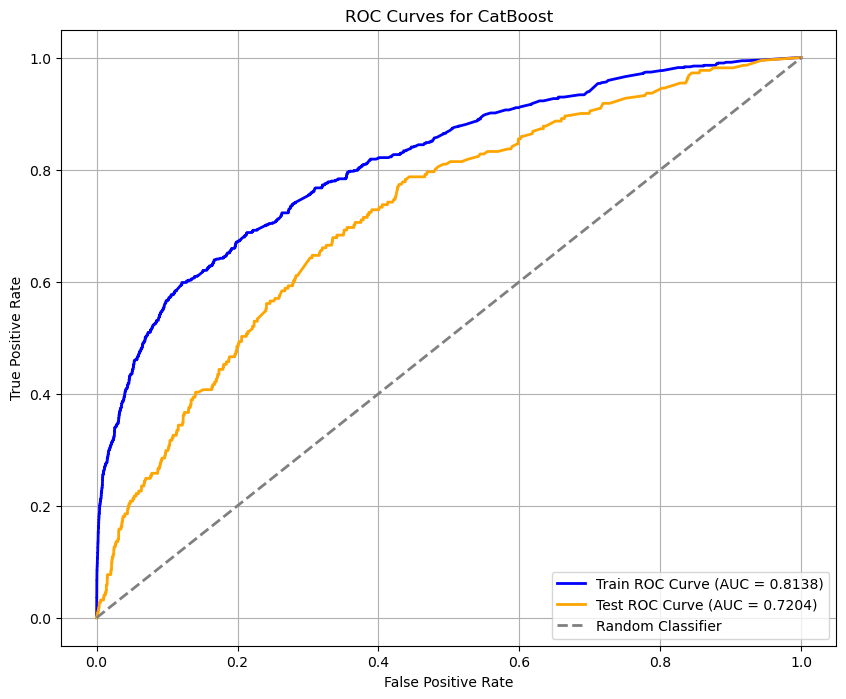

In [21]:
# Определение лучшей модели на основе ROC AUC на тестовой выборке
best_model_name = max(results, key=lambda x: results[x]["roc_auc_test"])
best_model_info = results[best_model_name]
print(f"\nЛучшая модель: {best_model_name} с ROC AUC на тестовой выборке = {best_model_info['roc_auc_test']:.4f}")

# Предсказания вероятностей для тренировочной и тестовой выборок
y_pred_train_proba = best_model.predict_proba(X_train)[:, 1]
y_pred_test_proba = best_model.predict_proba(X_test)[:, 1]

# Построение ROC-кривых
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Визуализация ROC-кривых
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC Curve (AUC = {roc_auc_train:.4f})')
plt.plot(fpr_test, tpr_test, color='orange', lw=2, label=f'Test ROC Curve (AUC = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves for {best_model_name}')
plt.legend(loc='lower right')
plt.grid()
plt.show()

На основании ROC-curve делаем вывод об отсутствии переобучения лучшей модели.

# Оценка лучших моделей по матрице ошибок

[LightGBM] [Info] Number of positive: 740, number of negative: 39139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1841
[LightGBM] [Info] Number of data points in the train set: 39879, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018556 -> initscore=-3.968225
[LightGBM] [Info] Start training from score -3.968225


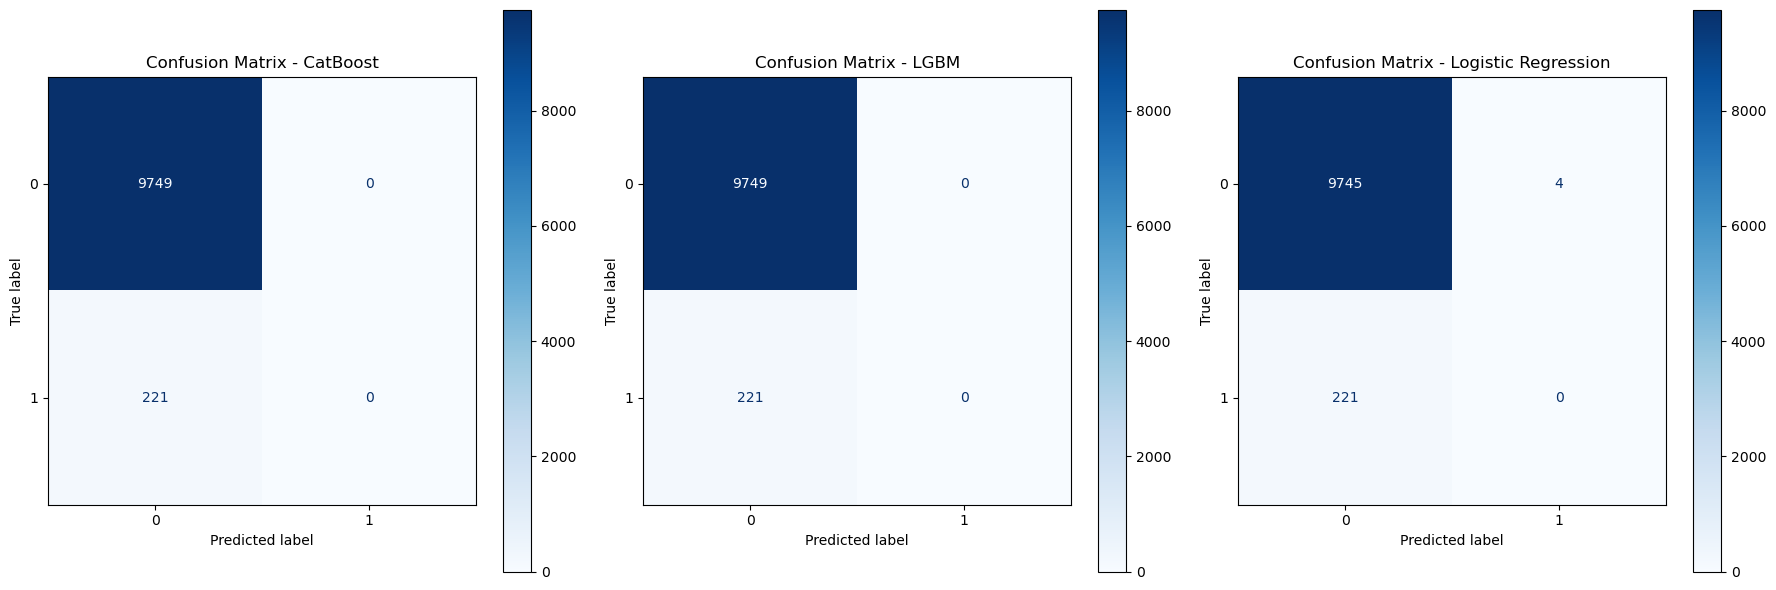


Classification Report - CatBoost:
              precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99      9749
     Class 1       0.00      0.00      0.00       221

    accuracy                           0.98      9970
   macro avg       0.49      0.50      0.49      9970
weighted avg       0.96      0.98      0.97      9970


Classification Report - LGBM:
              precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99      9749
     Class 1       0.00      0.00      0.00       221

    accuracy                           0.98      9970
   macro avg       0.49      0.50      0.49      9970
weighted avg       0.96      0.98      0.97      9970


Classification Report - Logistic Regression:
              precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99      9749
     Class 1       0.00      0.00      0.00       221

    accuracy                           0.98      9970
   macro avg    

G:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
G:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
G:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
G:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: Unde

In [22]:
# Лучшая модель CatBoost
catboost_model = CatBoostClassifier(verbose=0, **results["CatBoost"]["best_params"])
catboost_model.fit(X_train, y_train)
y_pred_catboost = catboost_model.predict(X_test)
cm_catboost = confusion_matrix(y_test, y_pred_catboost)

# Лучшая модель LGBM
lgbm_model = LGBMClassifier(**results["LGBM"]["best_params"])
lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict(X_test)
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)

# Лучшая модель Logistic Regression
logreg_model = LogisticRegression(**results["Logistic Regression"]["best_params"])
logreg_model.fit(X_train, y_train)
y_pred_logreg = logreg_model.predict(X_test)
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

# Визуализация матриц ошибок
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# CatBoost
disp_catboost = ConfusionMatrixDisplay(confusion_matrix=cm_catboost, display_labels=[0, 1])
disp_catboost.plot(ax=axes[0], cmap="Blues")
axes[0].set_title("Confusion Matrix - CatBoost")

# LGBM
disp_lgbm = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm, display_labels=[0, 1])
disp_lgbm.plot(ax=axes[1], cmap="Blues")
axes[1].set_title("Confusion Matrix - LGBM")

# Logistic Regression
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=[0, 1])
disp_logreg.plot(ax=axes[2], cmap="Blues")
axes[2].set_title("Confusion Matrix - Logistic Regression")

plt.tight_layout()
plt.show()

# Отчет классификации для каждой модели
print("\nClassification Report - CatBoost:")
print(classification_report(y_test, y_pred_catboost, target_names=["Class 0", "Class 1"]))

print("\nClassification Report - LGBM:")
print(classification_report(y_test, y_pred_lgbm, target_names=["Class 0", "Class 1"]))

print("\nClassification Report - Logistic Regression:")
print(classification_report(y_test, y_pred_logreg, target_names=["Class 0", "Class 1"]))

Анализ результатов:

Высокая точность для класса 0:

Precision, Recall и F1-score для класса 0 почти равны 1.0. Это связано с доминирующим количеством объектов класса 0.

Нулевая производительность для класса 1:

Precision, Recall и F1-score для класса 1 равны 0.00.
Это означает, что модели не сделали ни одного правильного предсказания для положительного класса.

Общая Accuracy:

Значение Accuracy (98%) вводит в заблуждение, так как обусловлено доминирующим количеством объектов класса 0.

Macro avg и Weighted avg:

Macro avg демонстрирует средние значения Precision и Recall для обоих классов, что подчеркивает дисбаланс в метриках.
Weighted avg взвешивает метрики в зависимости от количества объектов каждого класса, поэтому более близок к метрикам класса 0.

Почему модели не справляются с задачей:

Дисбаланс в тестовой выборке:

Класс 0 преобладает (97.8% данных), и модели оптимизируют метрики за счет игнорирования редкого класса.


Тем не менее, основная цель достигнута, модель показала результат - выше 0.7

In [24]:
pip freeze  > requirements.txt

Note: you may need to restart the kernel to use updated packages.
